# Reshape Statistics Into Image

### import packages

In [1]:
import pickle
import json

import numpy as np
import pandas as pd

import cv2
from skimage import filters
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from matplotlib.colors import ListedColormap

from tqdm.notebook import tqdm

### settings

In [2]:
with open('../models/palette.pkl', 'rb') as fp:
    color_palette = pickle.load(fp)

with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

my_order = settings_dict['my_order']

with open('../data/interim/im_dims.json', 'r') as fp:
    dim_dict = json.load(fp)

n_rows = dim_dict['n_rows']
n_cols = dim_dict['n_cols']
new_n_rows = dim_dict['new_n_rows']
new_n_cols = dim_dict['new_n_cols']
scale_factor = dim_dict['scale_factor']

### make thresholded image

* uses raw values
* thresholds by five sigma t-test based p-value
* thresholds also by sample size so that only pixels with data from at least 20 participants are considered

In [3]:
def make_thresh_im(this_df, p, n, new_n_rows=new_n_rows, new_n_cols=new_n_cols):
    
    mean_data = this_df .loc['mean', :]
    tp_data = this_df.loc['tp', :]
    n_data = this_df.loc['n df', :]
        
    thresh_data = mean_data * (tp_data<p)
    thresh_data = thresh_data * (n_data>=n)
    thresh_data = thresh_data.replace(0, np.nan)
    im = thresh_data.values.reshape(new_n_rows, new_n_cols)
    
    return im

### do this with values as they are

In [4]:
def make_one_im(emo1, emo2, cond1, comparison, p, n):
    
    fu = pd.read_csv(f'../data/processed/stat_{cond1}_{comparison}_df.tsv', sep='\t', index_col=[0, 1, 2])
    
    im1 = make_thresh_im(fu.loc[(emo1, emo2), :], p, n)

    return im1

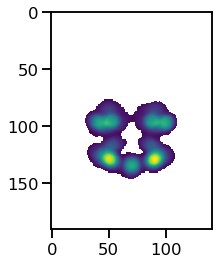

In [5]:
plt.imshow(make_one_im('Happy', 'Happy', 'Full', 'baseline', p=settings_dict['p'], n=20))

### do this for two halves

So that we can merge the results for the upper/lower mask conditions into one image.
This is clumsy, but computing statitics first and merging last is necessary to make sure that inferential stats are based on correct sample sizes.

In [6]:
def make_combi_im(emo1, emo2, cond1, cond2, comparison, p, n):
    
    fu = pd.read_csv(f'../data/processed/stat_{cond1}_{comparison}_df.tsv', sep='\t', index_col=[0, 1, 2])
    fa = pd.read_csv(f'../data/processed/stat_{cond2}_{comparison}_df.tsv', sep='\t', index_col=[0, 1, 2])
    
    im1 = make_thresh_im(fu.loc[(emo1, emo2), :], p, n)
    im2 = make_thresh_im(fa.loc[(emo1, emo2), :], p, n)
    
    im1 = pd.DataFrame(im1).replace(np.nan, 0).values
    im2 = pd.DataFrame(im2).replace(np.nan, 0).values
    
    merge_im = im1 + im2
    merge_im = pd.DataFrame(merge_im).replace(0, np.nan).values
    
    return merge_im

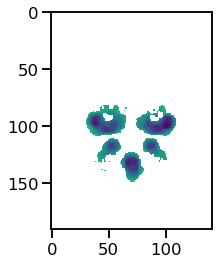

In [7]:
im = make_combi_im('Happy', 'Happy', 'Full_gr_Upper', 'Full_gr_Lower', 'baseline', p=settings_dict['p'], n=20)
plt.imshow(im)

## Make all Images

In [8]:
cond_dict = {'Full_gr_Half': ('Full_gr_Upper', 'Full_gr_Lower'),
             'Half': ('Upper', 'Lower'),
             'Full': 'Full'
            }

In [9]:
def make_results_dict(p, n):
    
    results_dict = {}

    # different masking conditions
    for key in tqdm(cond_dict):

        results_dict[key] = {}

        # there is the simple full cond and the two-part split cond
        try:
            cond1, cond2 = cond_dict[key]
        except:
            cond1 = cond_dict[key]

        for comparison in tqdm(['baseline', 'clean', 'confusions'], leave=False):

            try:
                results_dict[key][comparison] = {}

                for emo1 in tqdm(my_order, leave=False):
                    for emo2 in tqdm(my_order, leave=False):

                        # if combination exists
                        try:
                            # either simple version or two-halves version
                            if key == 'Full':
                                im = make_one_im( emo1, emo2, cond1, comparison, p, n )
                            else:
                                im = make_combi_im(emo1, emo2, cond1, cond2, comparison, p, n)

                        # some combinations do not exist and have to be filled with nans        
                        except:
                            im = np.zeros((new_n_rows, new_n_cols)) * np.nan                    

                        emo_str = str(emo1)+'-'+str(emo2)
                        results_dict[key][comparison][emo_str] = im    
            
            except:
                print(key, comparision)
                
    return results_dict

In [10]:
results_dict = make_results_dict(p=settings_dict['p'], n=20)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

#### Store

In [11]:
with open('../data/processed/stat_ims.json', 'wb') as fp:
    pickle.dump(results_dict, fp)

#### Liberally Thresholded Version

In [12]:
lothresh_results_dict = make_results_dict(p=0.05, n=10)
with open('../data/processed/lothresh_stat_ims.json', 'wb') as fp:
    pickle.dump(lothresh_results_dict, fp)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

#### Unthresh Version

In [13]:
unthresh_results_dict = make_results_dict(p=1, n=10)
with open('../data/processed/unthresh_stat_ims.json', 'wb') as fp:
    pickle.dump(unthresh_results_dict, fp)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

### Visualize

In [14]:
this_dict = lothresh_results_dict['Full']['confusions']

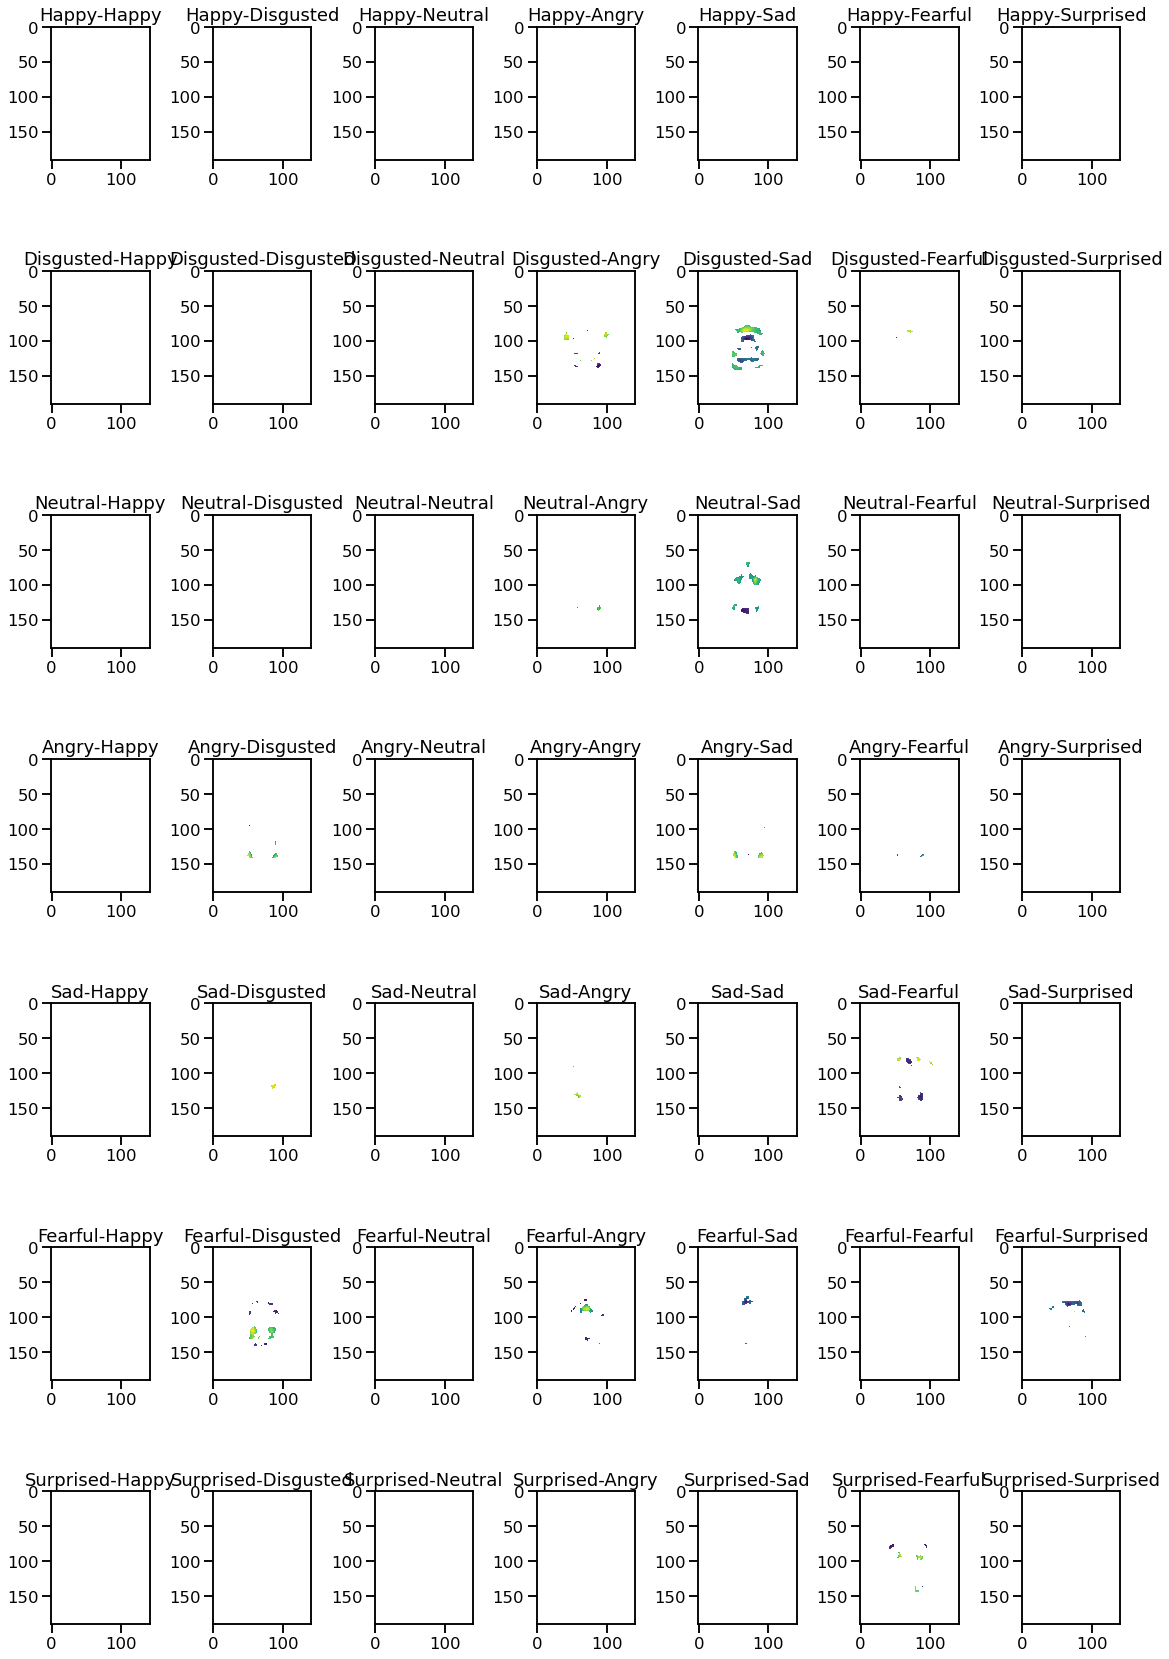

In [15]:
fig = plt.figure(figsize=(16, 24))

count = 1
for emo1 in my_order:
    for emo2 in my_order:
        
        ax = plt.subplot(len(my_order), len(my_order), count)
        this = f'{emo1}-{emo2}'
        ax.imshow(this_dict[this])
        ax.set_title(this)
        
        count += 1

plt.tight_layout()
plt.show()

In [16]:
this_dict = results_dict['Half']['clean']

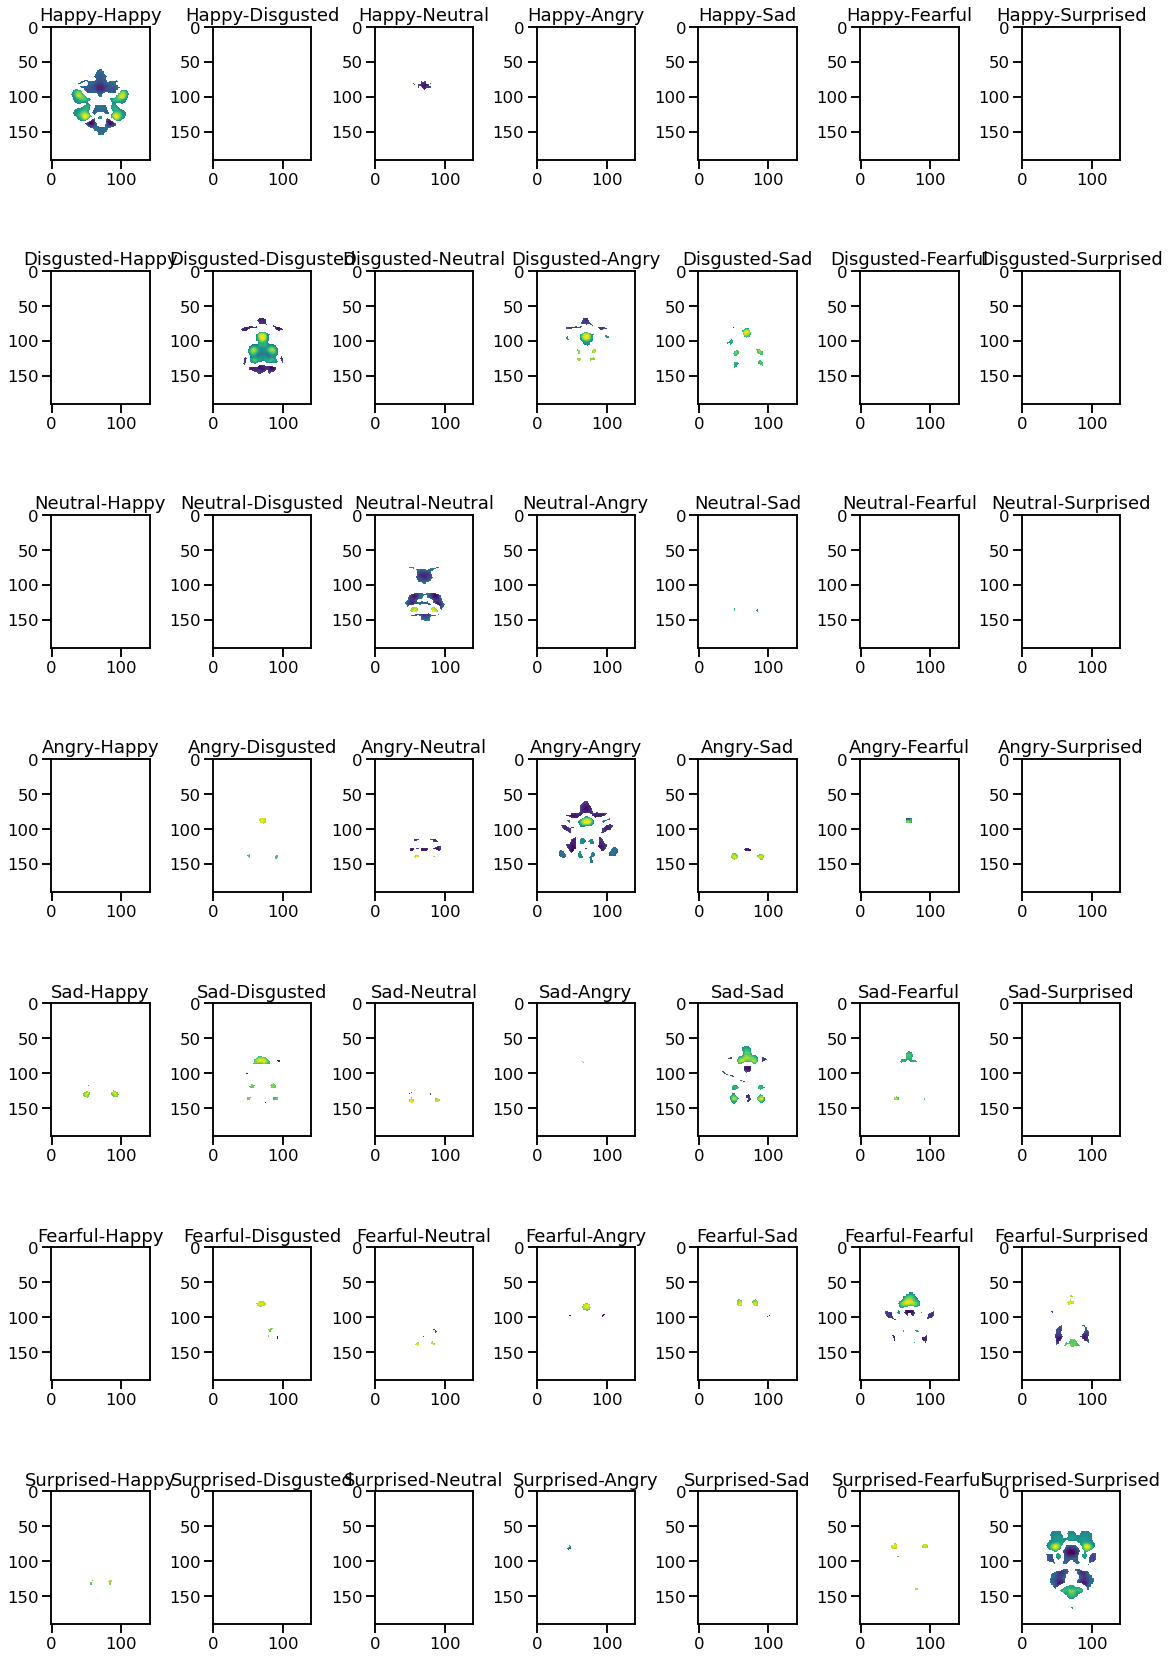

In [17]:
fig = plt.figure(figsize=(16, 24))

count = 1
for emo1 in my_order:
    for emo2 in my_order:
        
        ax = plt.subplot(len(my_order), len(my_order), count)
        this = f'{emo1}-{emo2}'
        ax.imshow(this_dict[this])
        ax.set_title(this)
        
        count += 1

plt.tight_layout()
plt.show()

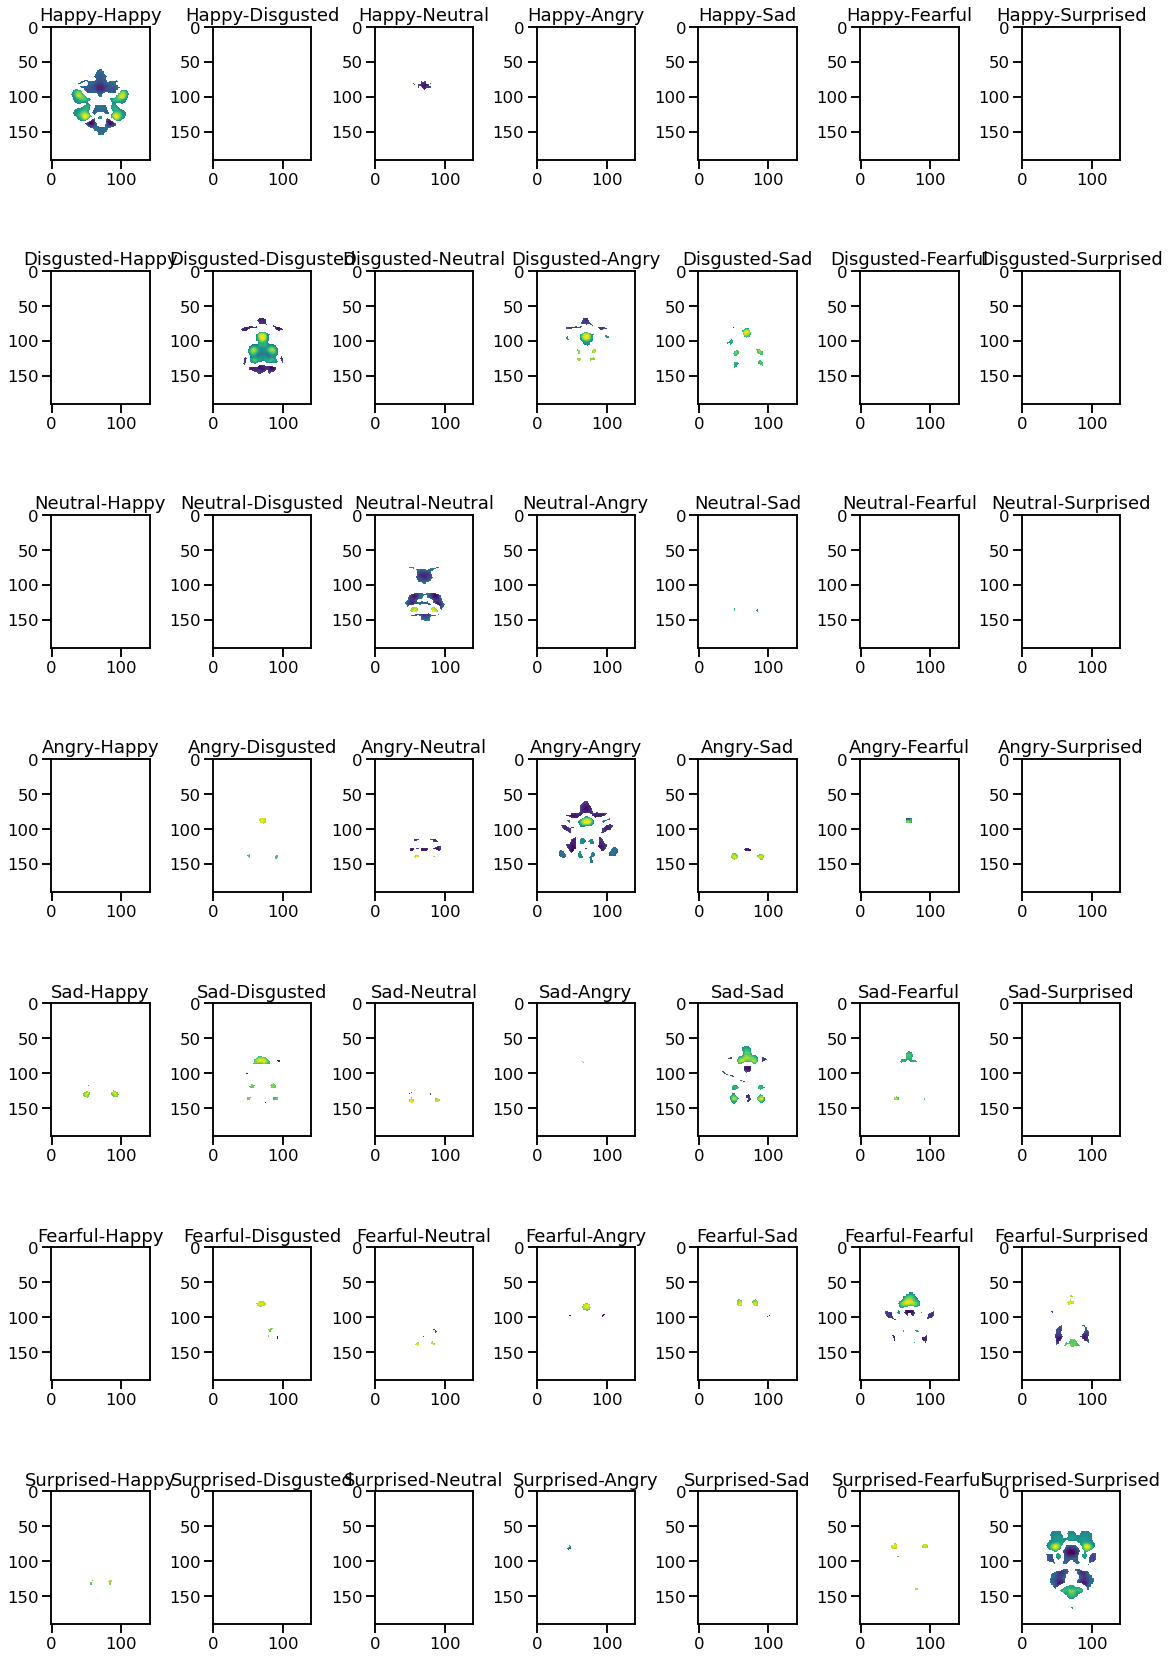

In [18]:
fig = plt.figure(figsize=(16, 24))

count = 1
for emo1 in my_order:
    for emo2 in my_order:
        
        ax = plt.subplot(len(my_order), len(my_order), count)
        this = f'{emo1}-{emo2}'
        ax.imshow(this_dict[this])
        ax.set_title(this)
        
        count += 1

plt.tight_layout()
plt.show()

In [19]:
this_dict = unthresh_results_dict['Full']['clean']

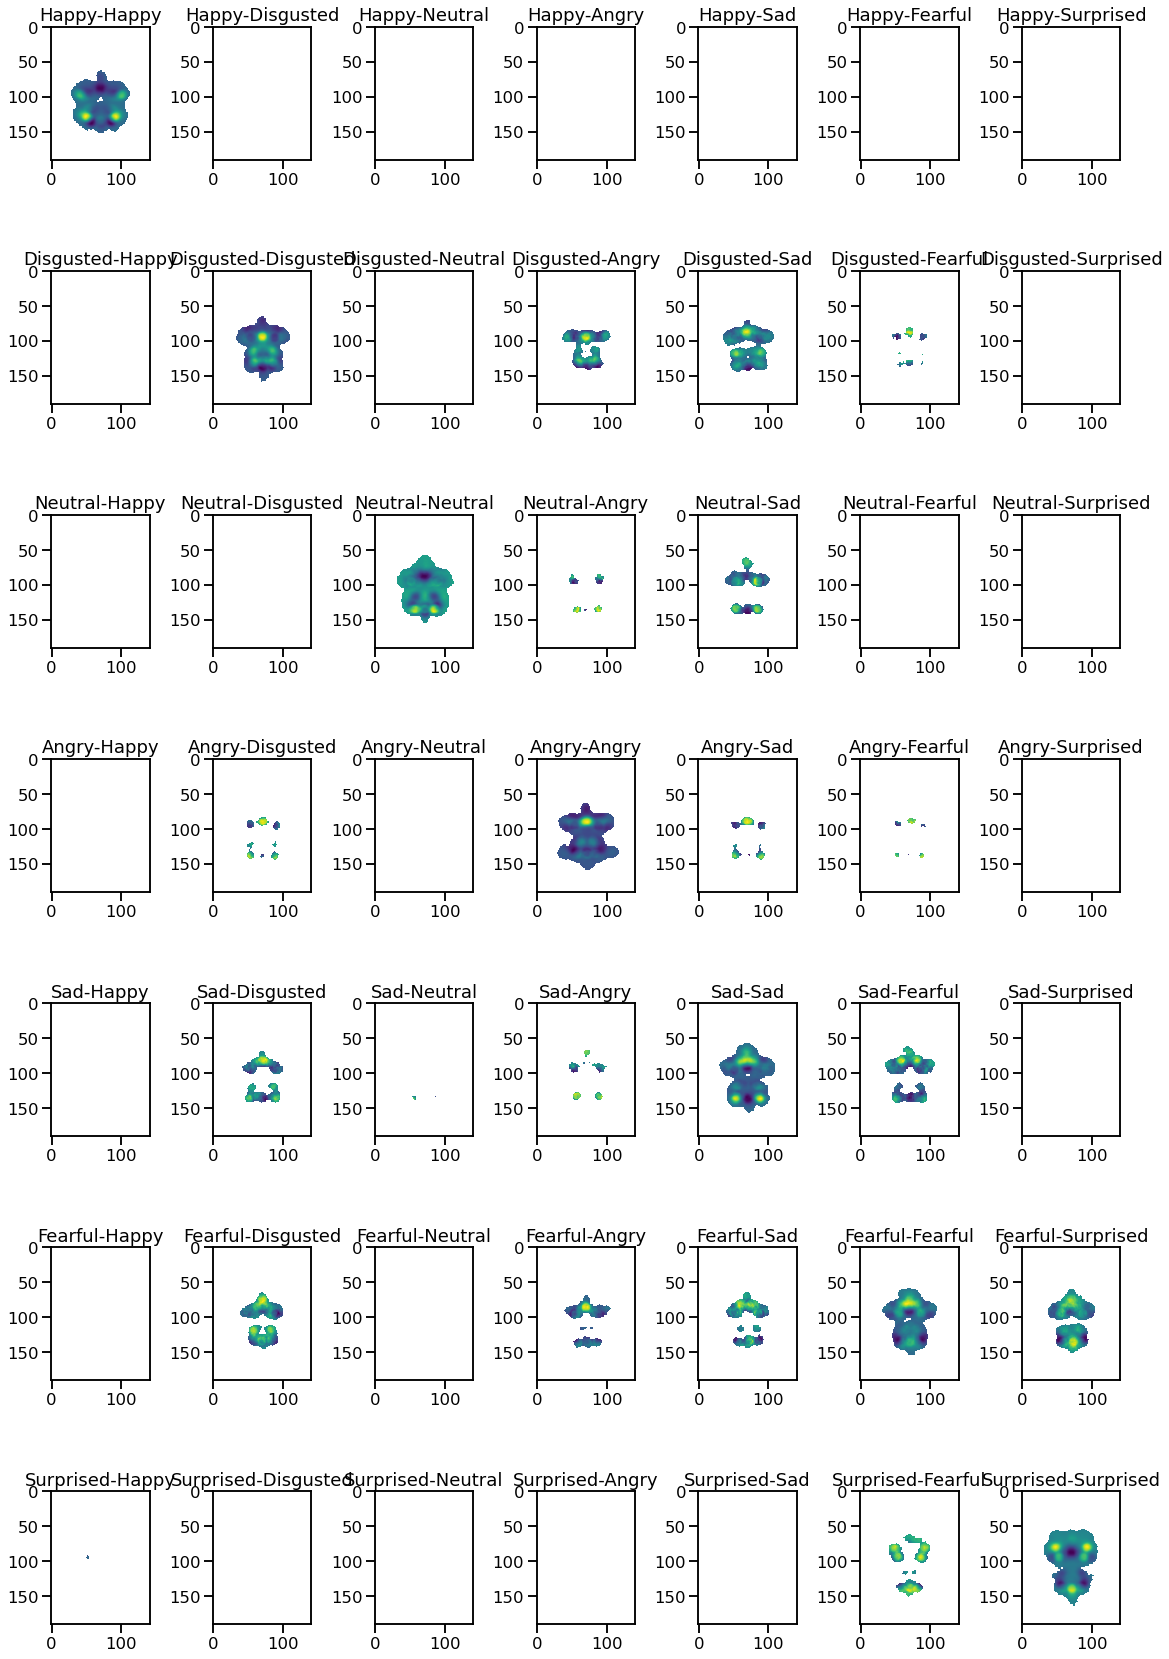

In [20]:
fig = plt.figure(figsize=(16, 24))

count = 1
for emo1 in my_order:
    for emo2 in my_order:
        
        ax = plt.subplot(len(my_order), len(my_order), count)
        this = f'{emo1}-{emo2}'
        ax.imshow(this_dict[this])
        ax.set_title(this)
        
        count += 1

plt.tight_layout()
plt.show()